In [1]:
#MacOS 兼容性操作
import ssl
import certifi

ssl._create_default_https_context = ssl._create_unverified_context

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Flatten

import altair as alt
from sklearn.preprocessing import MinMaxScaler

from keras.models import load_model

import nbimporter
import joblib

from sklearn.metrics import mean_squared_error, r2_score

In [3]:
model = load_model('BTC_predict_test3.keras')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
scaler = joblib.load('scaler.pkl')

In [5]:
data = pd.read_csv('../BTC_price_train/ver2/BTC_price_train.csv')
data.head()

,timeOpen,Close,Open,High,Low,volume,Chg.(%)
0,2014/1/1,815.9,805.9,829.9,771.0,10760.0,0.01
1,2014/1/2,856.9,815.9,886.2,810.5,12810.0,0.05
2,2014/1/3,884.3,856.9,888.2,839.4,9710.0,0.03
3,2014/1/4,924.7,884.3,932.2,848.3,14240.0,0.05
4,2014/1/5,1014.7,924.7,1029.9,911.4,21370.0,0.10


In [6]:
price = data.drop(['timeOpen', 'Chg.(%)'], axis=1)

In [7]:
scaled_price = scaler.transform(price)

In [8]:
def extract_data(data, time_step):
    X = []
    y = []
    for i in range(len(data) - time_step):
        X.append([a for a in data[i: i + time_step]])
        y.append(data[i + time_step, :]) 
    X = np.array(X)
    y = np.array(y)
    return X, y

In [9]:
time_step = 30
#define X and y
X, y = extract_data(scaled_price, time_step)
print(X.shape, y.shape)

(3027, 30, 5) (3027, 5)


In [10]:
#make prediction on the training data
y_train_predictions_norm = model.predict(X)

# 反归一化预测结果
y_train_predictions = scaler.inverse_transform(y_train_predictions_norm)
y_train_predictions_close = y_train_predictions[:, 0]

95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step


In [11]:
# 反归一化实际结果
y_train = scaler.inverse_transform(y)

y_train_close = y_train[:, 0]

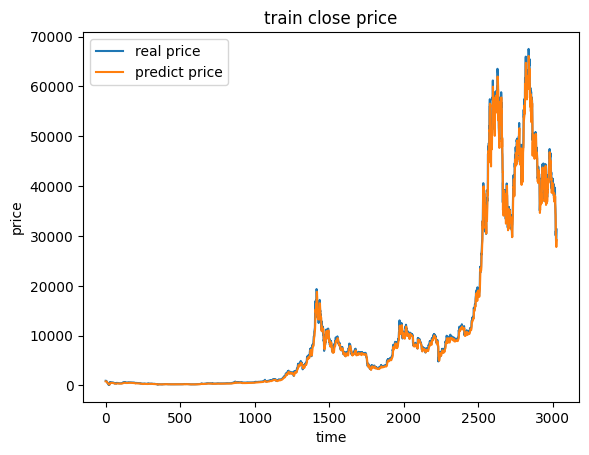

In [12]:
time = list(range(len(y_train_close)))

fig1 = plt.figure()
plt.plot(time, y_train_close, label='real price')
plt.plot(time, y_train_predictions_close, label='predict price')
plt.title('train close price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [15]:
print(y_train.shape)
print(y_train_predictions.shape)
#建立一个模型,将y_train与y_train_predictions相关联
#尝试CNN模型 希望效果:将y_train_predictions输入模型获得一个更接近y_train的值

# 调整数据形状
X_adjust_train = y_train_predictions_norm.reshape(-1, 1, 5)  # 变为 (样本数, 时间步长, 特征数)
y_adjust_train = y.reshape(-1, 5)          # 变为 (样本数, 特征数)



(3027, 5)
(3027, 5)


In [16]:
# 构建CNN模型
adjust_model_cnn = Sequential()
adjust_model_cnn.add(Conv1D(64, kernel_size=1, activation='relu', input_shape=(1, 5)))
adjust_model_cnn.add(Flatten())
adjust_model_cnn.add(Dense(50, activation='relu'))
adjust_model_cnn.add(Dense(5, activation='linear'))
adjust_model_cnn.compile(optimizer='adam', loss='mse')

adjust_model_cnn.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,889 (15.19 KB)

 Trainable params: 3,889 (15.19 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# 训练CNN模型
adjust_model_cnn.fit(X_adjust_train, y_adjust_train, epochs=50, batch_size=32, verbose=2, shuffle=False)

Epoch 1/50
95/95 - 2s - 24ms/step - loss: 0.0071
Epoch 2/50
95/95 - 1s - 9ms/step - loss: 0.0077
Epoch 3/50
95/95 - 1s - 9ms/step - loss: 0.0016
Epoch 4/50
95/95 - 1s - 9ms/step - loss: 7.4382e-04
Epoch 5/50
95/95 - 1s - 9ms/step - loss: 5.4402e-04
Epoch 6/50
95/95 - 1s - 9ms/step - loss: 4.9953e-04
Epoch 7/50
95/95 - 1s - 9ms/step - loss: 4.9747e-04
Epoch 8/50
95/95 - 1s - 9ms/step - loss: 5.6660e-04
Epoch 9/50
95/95 - 1s - 9ms/step - loss: 6.1268e-04
Epoch 10/50
95/95 - 1s - 8ms/step - loss: 7.3167e-04
Epoch 11/50
95/95 - 1s - 8ms/step - loss: 7.2569e-04
Epoch 12/50
95/95 - 1s - 8ms/step - loss: 7.7203e-04
Epoch 13/50
95/95 - 1s - 8ms/step - loss: 8.6734e-04
Epoch 14/50
95/95 - 1s - 9ms/step - loss: 7.1894e-04
Epoch 15/50
95/95 - 1s - 9ms/step - loss: 8.0890e-04
Epoch 16/50
95/95 - 1s - 8ms/step - loss: 0.0010
Epoch 17/50
95/95 - 1s - 8ms/step - loss: 0.0014
Epoch 18/50
95/95 - 1s - 9ms/step - loss: 0.0016
Epoch 19/50
95/95 - 1s - 9ms/step - loss: 0.0013
Epoch 20/50
95/95 - 1s - 8ms/

In [18]:
# 用调整后的CNN模型进行预测
y_train_pred_adjusted_cnn = adjust_model_cnn.predict(X_adjust_train)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [19]:
# 评估CNN模型
mse_train_cnn = mean_squared_error(y_adjust_train, y_train_pred_adjusted_cnn)
r2_train_cnn = r2_score(y_adjust_train, y_train_pred_adjusted_cnn)

print(f'训练集MSE: {mse_train_cnn}, R²: {r2_train_cnn}')

训练集MSE: 0.000286098471527733, R²: 0.9328173640852345


In [22]:
#反归一化
y_adjust_train_raw = scaler.inverse_transform(y_adjust_train)
y_train_pred_adjusted_cnn_raw = scaler.inverse_transform(y_train_pred_adjusted_cnn)

In [23]:
y_adjust_train_close = y_adjust_train_raw[:, 0]
y_train_pred_adjusted_cnn_close = y_train_pred_adjusted_cnn_raw[:, 0]

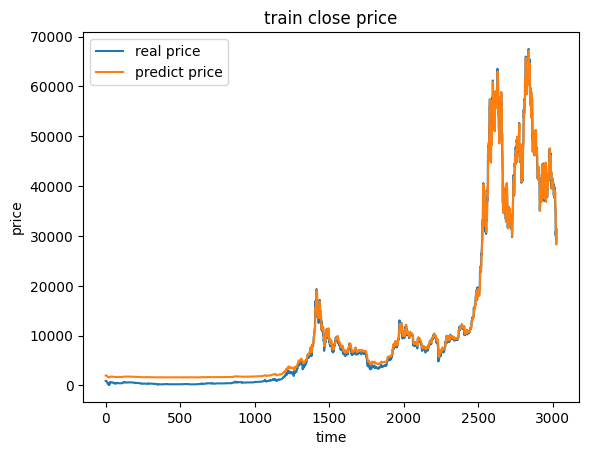

In [24]:
time_cnn = list(range(len(y_adjust_train_close)))

fig2 = plt.figure()
plt.plot(time, y_adjust_train_close, label='real price')
plt.plot(time, y_train_pred_adjusted_cnn_close, label='predict price')
plt.title('train close price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [25]:
'''
#输出结果
result_y_test = y_adjust_train_close.reshape(-1, 1)
result_y_predict = y_train_pred_adjusted_cnn_close.reshape(-1, 1)

result = np.concatenate((result_y_test, result_y_predict), axis=1)
print(result.shape)

result = pd.DataFrame(result, columns=['real_price', 'predict_price'])
result.to_csv('BTC_predict_retrain.csv')
'''


(3027, 2)


In [26]:
data_test = pd.read_csv('../BTC_price_train/ver2/BTC_price_test.csv')
data_test.head()

,timeOpen,Close,Open,High,Low,volume,Chg.(%)
0,2022/5/16,29849.0,31308.3,31312.4,29135.8,100250.0,-0.05
1,2022/5/17,30437.5,29856.7,30720.1,29484.5,79630.0,0.02
2,2022/5/18,28683.7,30437.5,30687.9,28648.1,92030.0,-0.06
3,2022/5/19,30305.9,28700.4,30525.1,28682.1,101380.0,0.06
4,2022/5/20,29178.6,30305.9,30735.1,28738.5,98780.0,-0.04


In [33]:
price_test = data_test.drop(['timeOpen', 'Chg.(%)'], axis=1)

In [34]:
scaled_price_test = scaler.transform(price_test)
print(scaled_price_test.shape)

(764, 5)


In [35]:
X_test, y_test = extract_data(scaled_price_test, time_step)
print(X_test.shape, y_test.shape)

(734, 30, 5) (734, 5)


In [40]:
#make prediction on the test data
y_test_predictions_norm = model.predict(X_test)

print(y_test_predictions_norm)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
[[ 0.32269332  0.32144007  0.33089203  0.31231523 -0.00178555]
 [ 0.31500095  0.3145818   0.32369864  0.3055791  -0.00243304]
 [ 0.3067196   0.3063857   0.31506974  0.29783306 -0.00238841]
 ...
 [ 0.9490039   0.9640849   0.9634847   0.9528645  -0.00736197]
 [ 0.95512635  0.96999186  0.9692116   0.95961106 -0.007162  ]
 [ 0.9601481   0.9744583   0.973606    0.9651475  -0.00667094]]


In [41]:
print(y_test)

[[3.33247301e-01 3.26710879e-01 3.28260001e-01 3.02432552e-01
  6.26733817e-05]
 [3.00743292e-01 3.33243346e-01 3.30986990e-01 3.04022149e-01
  3.21566014e-05]
 [3.01603618e-01 3.00809439e-01 3.07353571e-01 3.04218395e-01
  3.04272948e-05]
 ...
 [9.80644147e-01 9.77830550e-01 9.63036735e-01 9.93360828e-01
  5.32214796e-06]
 [9.87344307e-01 9.80632510e-01 9.70373599e-01 9.95519540e-01
  4.58165575e-06]
 [9.72215918e-01 9.87305891e-01 9.69525138e-01 9.87240955e-01
  7.90604073e-06]]


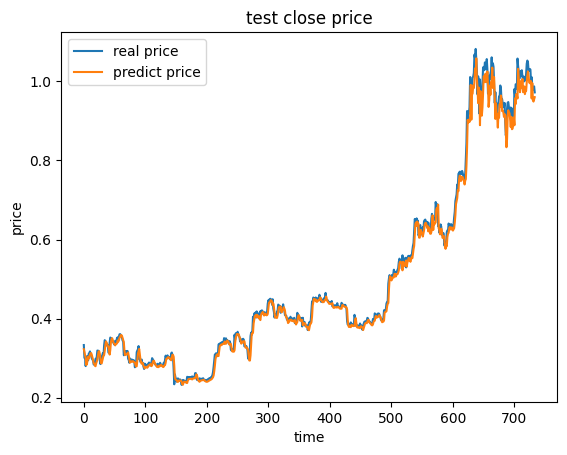

In [43]:
time = list(range(len(y_test)))

fig1 = plt.figure()
plt.plot(time, y_test[:, 0], label='real price')
plt.plot(time, y_test_predictions_norm[:, 0], label='predict price')
plt.title('test close price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [49]:
# 调整数据形状
X_adjust_test = y_test_predictions_norm.reshape(-1, 1, 5)  # 变为 (样本数, 时间步长, 特征数)
y_adjust_test = y_test.reshape(-1, 5)   

In [50]:
# 用CNN模型进行修正
y_test_pred_adjusted_cnn = adjust_model_cnn.predict(X_adjust_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [67]:
print(y_test_pred_adjusted_cnn.shape)

(734, 5)


In [52]:
# 评估CNN模型
mse_test_cnn = mean_squared_error(y_adjust_test[:, 0], y_test_pred_adjusted_cnn[:, 0])
r2_test_cnn = r2_score(y_adjust_test[:, 0], y_test_pred_adjusted_cnn[:, 0])

print(f'测试集MSE: {mse_test_cnn}, R²: {r2_test_cnn}')

测试集MSE: 0.00025481037012546544, R²: 0.9955587958927257


In [53]:
#反归一化
y_adjust_test_raw = scaler.inverse_transform(y_adjust_test)
y_test_pred_adjusted_cnn_raw = scaler.inverse_transform(y_test_pred_adjusted_cnn)

In [54]:
y_adjust_test_close = y_adjust_test_raw[:, 0]
y_test_pred_adjusted_cnn_close = y_test_pred_adjusted_cnn_raw[:, 0]

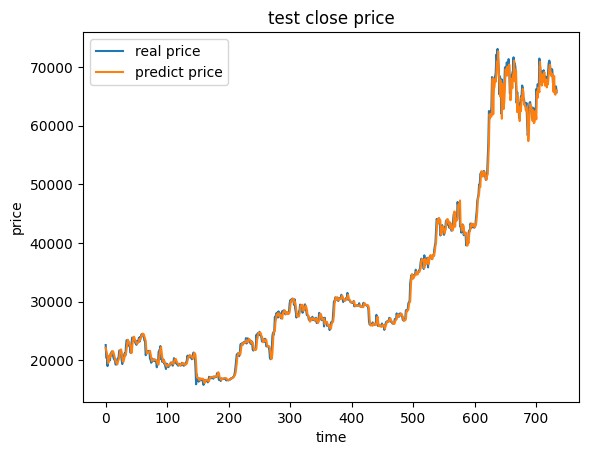

In [55]:
time_cnn_test = list(range(len(y_adjust_test_close)))

fig2 = plt.figure()
plt.plot(time, y_adjust_test_close, label='real price')
plt.plot(time, y_test_pred_adjusted_cnn_close, label='predict price')
plt.title('test close price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [56]:
#输出结果
result_y_test = y_adjust_test_close.reshape(-1, 1)
result_y_predict = y_test_pred_adjusted_cnn_close.reshape(-1, 1)

result = np.concatenate((result_y_test, result_y_predict), axis=1)
print(result.shape)

result = pd.DataFrame(result, columns=['real_price', 'predict_price'])
result.to_csv('BTC_predict_retrain.csv')

(734, 2)


In [68]:
#定义函数
def predict_and_update(model, model_cnn, scaled_data, num_predictions):

    predictions = []
    for _ in range(num_predictions):
        # 预测
        predict = model.predict(scaled_data)
        # 调整数据形状
        predict_adjust = predict.reshape(-1, 1, 5)
        # 用CNN模型进行修正
        predict_adjust_cnn = model_cnn.predict(predict_adjust)

        # 转换 predict 的形状并拼接
        scaled_data = np.concatenate([scaled_data, predict_adjust_cnn.reshape(predict_adjust_cnn.shape[0], 1, 5)], axis=1)

        # 删除第一个元素
        scaled_data = scaled_data[:, 1:]

        predictions.append(predict_adjust_cnn)

    return predictions

In [91]:
a = predict_and_update(model, adjust_model_cnn, X_test[-30:, :, :], 40)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━

In [92]:
a = np.array(a)
print(a.shape)

a_reshape_0 = a[:, 0, :].reshape(40, 5)
a_reshape_result_0 = scaler.inverse_transform(a_reshape_0)
#print(a_reshape_result)
a_close_result_0 = a_reshape_result_0[:, 0]
print(a_close_result_0)


(40, 30, 5)
[66266.26  64795.21  63462.117 62320.145 61313.812 60394.508 59536.848
 58728.605 57969.914 57261.285 56602.2   55990.688 55424.363 54900.508
 54415.934 53967.12  53550.76  53163.63  52802.9   52466.07  52150.723
 51854.57  51575.875 51312.98  51064.5   50829.113 50605.875 50393.715
 50191.594 49997.848 49811.953 49633.316 49461.5   49296.133 49136.863
 48983.4   48835.43  48692.715 48554.984 48422.008]


In [93]:
a_reshape_1 = a[:, 1, :].reshape(40, 5)
a_reshape_result_1 = scaler.inverse_transform(a_reshape_1)
a_close_result_1 = a_reshape_result_1[:, 0]
print(a_close_result_1)

[65683.19  64275.004 63014.703 61917.555 60934.793 60030.133 59184.082
 58390.707 57650.105 56961.688 56323.496 55733.117 55187.715 54683.92
 54217.97  53786.312 53385.46  53012.31  52664.184 52338.473 52032.777
 51745.227 51474.11  51217.953 50975.367 50745.344 50526.734 50318.867
 50120.117 49929.484 49746.414 49570.402 49401.03  49237.95  49080.84
 48929.406 48783.38  48642.496 48506.504 48375.188]


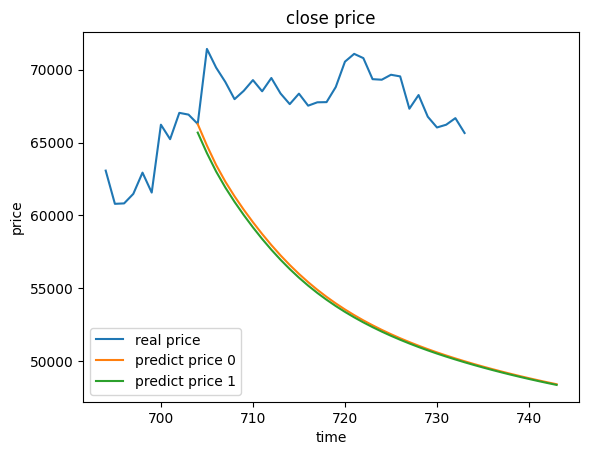

In [111]:
time = list(range(len(y_test)))
time_0 = list(range(len(y_test) - 30, len(y_test) - 30 + len(a_close_result_0)))

time_1 = list(range(len(y_test) - 30, len(y_test) - 30 + len(a_close_result_1)))


fig1 = plt.figure()
plt.plot(time[-len(time_0):], y_adjust_test_raw[-len(time_0):, 0], label='real price')
plt.plot(time_0, a_close_result_0, label='predict price 0')
plt.plot(time_1, a_close_result_1, label='predict price 1')

plt.title('close price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()